# Lab 3: EM and VAE

### Machine Learning 2 (2016/2017)

* The lab exercises should be made in groups of two people or individually.
* The hand-in deadline is Wednesday, May 24, 23:59.
* Assignment should be sent to p.j.j.p.versteeg@uva.nl. The subject line of your email should be "[ML2_2017] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[ML2_2017] lab02\_Bongers\_Blom", the attached file should be "lab02\_Bongers\_Blom.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask or e-mail Philip.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts before you send them!

$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included.

In [1]:
%pylab inline
import gzip
import _pickle as cPickle
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load data
with gzip.open('mnist_small.gz', 'r') as f:
    mnist_images, mnist_labels = cPickle.load(f, encoding = 'latin')

#mnist_dim = (28, 28)
# print "MNIST data loaded;", " number of samples:", len(mnist_labels), \ 
#      '; number of pixels per sample:', mnist_dim[0], 'x', mnist_dim[1]

## Part 1: Expectation Maximization
We use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5)
As we like to apply our Bernoulli mixture model, convert the MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding the dataset at an appropriate level. Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

In [3]:
# From ML1 lab 2, as discussed it's okay to use it
def plot_digits(data, numcols, shape=(28,28)):
    numdigits = data.shape[0]
    numrows = int(numdigits/numcols)
    for i in range(numdigits):
        plt.subplot(numrows, numcols, (i+1))
        plt.axis('off')
        plt.imshow(data[i].reshape(shape), interpolation='nearest', cmap='Greys')
    plt.show()

In [4]:
binary = np.zeros(mnist_images.shape)
for i in range(mnist_images.shape[0]):
    v = mnist_images[i,:] > .5
    binary[i,:] = [int(n) for n in v]


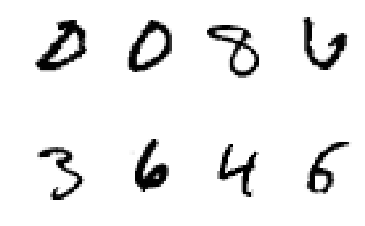

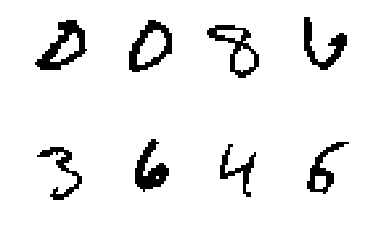

In [5]:
plot_digits(mnist_images[0:8],4)
plot_digits(binary[0:8],4)

### 1.2 Implementation (40)
Write a function ```EM(batch, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters your function should have are:
* ```batch``` :: input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize equations in ```numpy``` as  much as possible and clearly comment in your code where the E-step and where the M-step are performed.

In [6]:
def P_xn_muk ( x, mu_par, n):
    return np.prod ( ((mu_par ** x[n] ) * (1 - mu_par) ** (1-  x[n]) ) , 1) 

In [7]:
def logL (x, mu_par, pi_par):
    S = 0
    for n in range(x.shape[0]):
        S = S + np.log (sum (pi_par * P_xn_muk ( x = x, mu_par = mu_par, n=n )) )
    return S

In [8]:
def up_gamma (x, mu_par):
    n = x.shape[0]
    k = mu_par.shape[0]
    gamma = np.zeros([n,k])
    for i in range(n):
        p = P_xn_muk(x = x , mu_par = mu_par, n = i)
        gamma_n = p * pi / sum(p * pi)
        gamma[i,:]= gamma_n
    return gamma

In [9]:
def up_pi (gamma_znk_par):
    N_k = np.sum(gamma_znk_par,0)
    N   = sum(N_k)
    return N_k / N, N_k

In [10]:
def up_muk (x, N_k_par, gamma_par):
    return np.matrix.transpose(1/N_k_par * (np.dot (np.matrix.transpose(x) , gamma_par)))

In [68]:
def EM(batch, K, max_iter):
    x = batch
    #Initialize
    threshold = 0.000001 # maximum LL change for convergence
    D       = x.shape[1]
    mu      = np.random.uniform(.4,.6, size =  K*D ).reshape(K,D)
    pi      = 1/K * np.ones( K )
    # Calculate starting LL
    LL      = logL(x = x, mu_par = mu, pi_par = pi)
    # Start iterative EM optimization
    i       = 0
    epsilon = 1
    while( epsilon > threshold and max_iter > i):
        i   = i+1
        # E-step
        gamma_znk = up_gamma(x = x, mu_par = mu)
        # M-step
        pi, N_k   = up_pi(gamma_znk_par = gamma_znk)
        mu        = up_muk(x = x, N_k_par = N_k, gamma_par = gamma_znk)
        # Re-evaluate 
        LL_old    = LL
        LL        = logL(x = x, mu_par = mu, pi_par = pi)
        epsilon   = np.absolute(LL - LL_old)
        if( (i / 10).is_integer() ):
            print("Run ", i, "; Log-likelihood is ", LL)          
                         
    return pi, mu, gamma_znk, LL, i
    


In [12]:
#n = 1000
#pi_out, mu_out, LL_out, iterations = EM(batch = binary[np.random.randint(0,5000,n)], K = 10, max_iter = 1000)

#pi_out, mu_out, LL_out, iterations = EM(batch = binary[np.random.choice(np.arange(0,5001,1),size=n, replace=False)],
#                                        K = 10, max_iter = 1000)
#pi_out

In [13]:
#plot_digits(mu_out[0:10,:], numcols=5)

### 1.2 Three digits test (10)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits. What are the identified mixing coefficients, and how do these compare to the true ones?

In [14]:
digitlist = np.array([i==2 or i==3 or i==4 for i in mnist_labels])
subset_binary = binary[digitlist]
subset_labels = mnist_labels[digitlist]

Run  10 ; Log-likelihood is  -92605.5037319
Run  20 ; Log-likelihood is  -92551.8405893


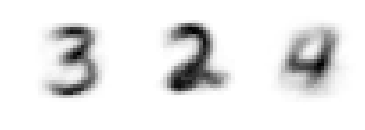

(3, 784)

In [50]:
n = 500
choice=np.random.choice(np.arange(0,subset_binary.shape[0],1),size=n, replace=False)
sample_subset_binary = subset_binary[choice]
sample_subset_labels = subset_labels[choice]
pi_out, mu_out, gamma_out, LL_out, iterations = EM(batch = sample_subset_binary, K = 3, max_iter = 1000)
plot_digits(mu_out, numcols=3)

In [16]:
true_pi = np.array([sum(sample_subset_labels == 2), sum(sample_subset_labels == 3), sum(sample_subset_labels  == 4)])/ sample_subset_labels.shape[0]

In [17]:
print("Estimated mixing coefficients: ", np.round(pi_out,3))
print("True mixing coefficients: ", np.round(true_pi,3))

Estimated mixing coefficients:  [ 0.232  0.3    0.468]
True mixing coefficients:  [ 0.356  0.304  0.34 ]


**Answer** The mixing coefficients are roughly the same, each taking up about 1/3 of the sample. However, depending on the random set of samples (and its size) the Bernoulli Mixture Model sometimes can have larger mis-classified numbers of samples leading to some $\pi_k$ close to .50 or .20.

### 1.3 More experiments (20)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation.

* __1.3.1__
    Use with more or less classes for $K$.
* __1.3.2__ 
    Use the image labels in ```mnist_labels``` to identify some misclassified images and see if you understand why.
* __1.3.3__ 
    Initialize the three classes with the true values of the parameters and see what happens.

**1.3.1**

In [39]:
n = 500
K_max = 10
choice=np.random.choice(np.arange(0,subset_binary.shape[0],1),size=n, replace=False)
sample_subset_binary = subset_binary[choice]
sample_subset_labels = subset_labels[choice]

pis = []
mus = []
LLs = []
for i in range(2,K_max+1) :
    pi_out, mu_out, gamma_out, LL_out, iterations = EM(batch = sample_subset_binary, K = i, max_iter = 1000)
    pis.append(pi_out)
    mus.append(mu_out)
    LLs.append(LL_out)

Run  10 ; Log-likelihood is  -94835.3420165
Run  20 ; Log-likelihood is  -94781.9045896
Run  10 ; Log-likelihood is  -90692.0611828
Run  20 ; Log-likelihood is  -90561.9317428
Run  10 ; Log-likelihood is  -87735.3980418
Run  20 ; Log-likelihood is  -87729.7740665
Run  30 ; Log-likelihood is  -87729.8001779
Run  10 ; Log-likelihood is  -86388.6681487
Run  20 ; Log-likelihood is  -86279.9681629
Run  30 ; Log-likelihood is  -86174.3355262
Run  40 ; Log-likelihood is  -86170.6894668
Run  10 ; Log-likelihood is  -85086.4404858
Run  20 ; Log-likelihood is  -84984.7097518
Run  30 ; Log-likelihood is  -84980.9333358
Run  40 ; Log-likelihood is  -84971.6902658
Run  10 ; Log-likelihood is  -82633.2035391
Run  20 ; Log-likelihood is  -82629.7655185
Run  10 ; Log-likelihood is  -82848.7536747
Run  20 ; Log-likelihood is  -82791.8484033
Run  10 ; Log-likelihood is  -81234.5071328
Run  20 ; Log-likelihood is  -81127.8253415
Run  30 ; Log-likelihood is  -81102.5215806
Run  10 ; Log-likelihood is  -80

** Answer ** Increasing the number of classes $K$ generally increases the flexibility of the model, and thus increases the maximum log likelihood (see Figure). One may choose a number of classes $K$ were the log-likelihood does not increase "steeply" anymore. Interestingly, the "correct" number of classes ($K=3$) is certainly not at a point where $K$ does not increase steeply anymore. Rather $K=5$ may be chosen. The steepest increases can be found when allowing for a new hand writing style for a given number, i.e. at $K=3$, $K=4$ and $K=7$. Additionally one may look at the plots of the coefficients for different $K$ (see also below). We see that for $K>2$ the three numbers are always identified and that for higher numbers slightly different varieties in writing style can be seen. For example, the number 2 can be written with a curved ending or straight. Also the lower part of the three shows differences and the vertical alignment of the 4 can be slightly sloped or straight.

<function matplotlib.pyplot.show>

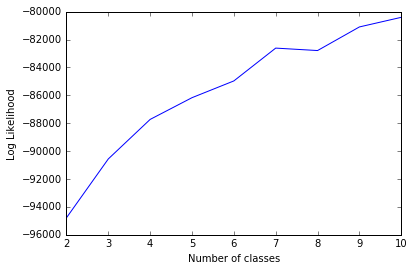

In [60]:
plt.plot( np.arange(2,K_max+1), LLs)
plt.ylabel('Log Likelihood')
plt.xlabel('Number of classes (K)')
plt.show

K = 2


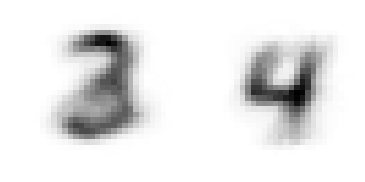

K = 3


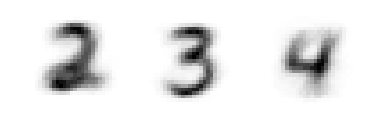

K = 4


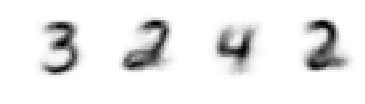

K = 5


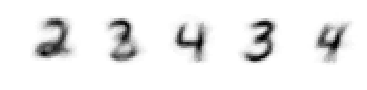

K = 6


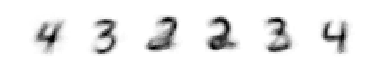

K = 7


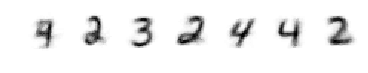

K = 10


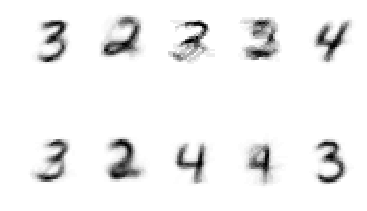

In [66]:
print("K = 2")
plot_digits(mus[0], numcols=2)
print("K = 3")
plot_digits(mus[1], numcols=3)
print("K = 4")
plot_digits(mus[2], numcols=4)
print("K = 5")
plot_digits(mus[3], numcols=5)
print("K = 6")
plot_digits(mus[4], numcols=6)
print("K = 7")
plot_digits(mus[5], numcols=7)
print("K = 10")
plot_digits(mus[8], numcols=5)

**1.3.2**

**Answer:** The misclassified numbers are those that are written in a very unusual / ambiguous way. For example, the first number is squashed together to the center looking like the middle range of the number 4.

Run  10 ; Log-likelihood is  -90734.6204694


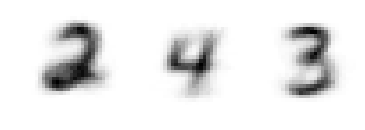

In [69]:
n = 500
choice=np.random.choice(np.arange(0,subset_binary.shape[0],1),size=n, replace=False)
sample_subset_binary = subset_binary[choice]
sample_subset_labels = subset_labels[choice]
pi_out, mu_out, gamma_out, LL_out, iterations = EM(batch = sample_subset_binary, K = 3, max_iter = 1000)
plot_digits(mu_out, numcols=3)



True labels  [2 2 2 3 2]


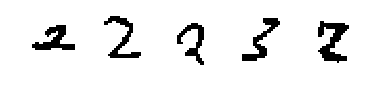

Assigned labels  [4 3 4 2 3]


In [99]:
max_z = np.argmax(gamma_out,1) 
# Hast to be coded manually depending on outcome of EM
max_z[max_z == 2] = 3
max_z[max_z == 0] = 2
max_z[max_z == 1] = 4
max_z

mis_clas = max_z != sample_subset_labels
sum(mis_clas)/n #misclssification rate

print("True labels ", sample_subset_labels[mis_clas == 1][0:5])
plot_digits(sample_subset_binary[mis_clas == 1][0:5],5)
print("Assigned labels ", max_z[mis_clas == 1][0:5])

** 1.3.3: Initializing mixing coefficients at true values **

In [101]:
def EM_ini(batch, K, max_iter, pi_ini):
    x = batch
    #Initialize
    threshold = 0.000001 # maximum LL change for convergence
    D       = x.shape[1]
    mu      = np.random.uniform(.4,.6, size =  K*D ).reshape(K,D)
    pi      = pi_ini
    # Calculate starting LL
    LL      = logL(x = x, mu_par = mu, pi_par = pi)
    # Start iterative EM optimization
    i       = 0
    epsilon = 1
    while( epsilon > threshold and max_iter > i):
        i   = i+1
        # E-step
        gamma_znk = up_gamma(x = x, mu_par = mu)
        # M-step
        pi, N_k   = up_pi(gamma_znk_par = gamma_znk)
        mu        = up_muk(x = x, N_k_par = N_k, gamma_par = gamma_znk)
        # Re-evaluate 
        LL_old    = LL
        LL        = logL(x = x, mu_par = mu, pi_par = pi)
        epsilon   = np.absolute(LL - LL_old)
        if( (i / 10).is_integer() ):
            print("Run ", i, "; Log-likelihood is ", LL)          
                         
    return pi, mu, gamma_znk, LL, i

Run  10 ; Log-likelihood is  -90718.3089809
Run  20 ; Log-likelihood is  -90712.456132
Run  30 ; Log-likelihood is  -90690.3003209
Run  40 ; Log-likelihood is  -90690.2960688
Run  50 ; Log-likelihood is  -90690.2957305
Run  60 ; Log-likelihood is  -90679.4311988
Run  70 ; Log-likelihood is  -90679.3905428
Run  80 ; Log-likelihood is  -90679.3903671


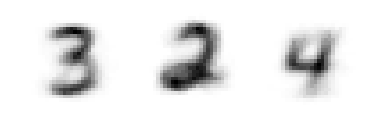

-90691.8945633 -90679.3903671


In [102]:
LL_out_old = LL_out
pi_out, mu_out, gamma_out, LL_out, iterations = EM_ini(batch = sample_subset_binary, K = 3, max_iter = 1000, pi_ini = true_pi)
plot_digits(mu_out, numcols=3)
print(LL_out_old, LL_out)

In [103]:
max_z = np.argmax(gamma_out,1) 
# Hast to be coded manually depending on outcome of EM
max_z[max_z == 2] = 4
max_z[max_z == 0] = 3
max_z[max_z == 1] = 2
max_z

mis_clas = max_z != sample_subset_labels
sum(mis_clas)/n #misclssification rate

0.156

### 1.4 Relation to Variational Inference (5)
Propose how you would alter the Bernoulli mixture model for use with a variational method (Bishop Ch.$10$). 

Which priors would you use and why? 

** Answer: ** In variational inference, which means a full Bayesian treatment of the Bernoulli Mixture model, the parmeters $\mu$ and $\pi$, which are assumed to be deterministic in the maximum likelihood approach, receive prior distirbutions. The most useful are conjugate priors. As $\mu$ are the parameters of a (multivariate) Bernoulli distribution, the conjudgate prior is the beta distirbution. The prior for the mixture parameters $\pi$ is usefully chosen as the Dirichlet distribution.



## Part 2: Variational Auto-Encoder
A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part, that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

More information can be found here:
* Original paper by Kingma (2014) https://arxiv.org/pdf/1312.6114.pdf 
* Nice but large summary (2016) https://arxiv.org/pdf/1606.05908.pdf
* One of _many_ online Tutorials, i.e. https://jaan.io/what-is-variational-autoencoder-vae-tutorial or http://kvfrans.com/variational-autoencoders-explained

### 2.1 The q-distribution (5 points)

In variational inference, we introduce distribution $q(\theta)$ over parameters / latent variables in order to make inference tractable. We can think of $q$ as being an approximation of a certain distribution. What function does $q$ approximate, $p(\bx|\theta)$, $p(\theta|\bx)$, $p(\bx, \theta)$, $p(\theta)$, or $p(\bx)$, and how do you see that from the equation $\ln p(\bx) = \mathcal{L}(q) + \mathrm{KL}(q||p)$? 


_YOUR ANSWER HERE_

### 2.2 Implementation (20 points)
Above is a version of a Variational Auto-Encoder that uses PyTorch (http://pytorch.org/). PyTorch is python package that is  particularly suited for high level programming of neural net, and is easily installable by following the instructions on their website.

Add comments to the code below, where each ```COMMENT``` line should be replaced with an explanation of the code on the line below it (this may also be one or two words) and specify the encoder and decoder parts. 

Modify the ```run(...)``` function to visualize each $200$ iterations how the model is improving. Do this by sampling a few values of the latent space $\bz$ and running those through the decoder. Add a plot of the loss function and show this after convergence. Run the 

In [ ]:
import torch
import torch.nn.functional as nn
from torch.autograd import Variable

## COMMENT
N_samples, X_dim = mnist_images.shape 
## COMMENT
mb_size = 64
## COMMENT
Z_dim = 100 
## COMMENT
h_dim = 128 
## COMMENT
lr = 1e-3

## Helper functions.
def mnist_mb(mb_size):
    """Sample batch of size mb_size from training data"""
    yield mnist_images[np.random.choice(N_samples, size=mb_size, replace=True),]
def init_weight(size):
    return Variable(torch.randn(*size) * (1. / np.sqrt(size[0] / 2.)), requires_grad=True)

## COMMENT
Wxh = init_weight(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)
Whz_mu = init_weight(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var = init_weight(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

## COMMENT
def Q(X):
    h = nn.relu(X.mm(Wxh) + bxh.repeat(X.size(0), 1))
    z_mu = h.mm(Whz_mu) + bhz_mu.repeat(h.size(0), 1)
    z_var = h.mm(Whz_var) + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var

## COMMENT
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps

## COMMENT
Wzh = init_weight(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
Whx = init_weight(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

## COMMENT
def P(z):
    h = nn.relu(z.mm(Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h.mm(Whx) + bhx.repeat(h.size(0), 1))
    return X

## COMMENT
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
solver = torch.optim.Adagrad(params, lr=lr)

def run(num_iter):
    for iter in range(num_iter):
        ## Load data.
        X = mnist_mb(mb_size=mb_size).next()
        X = Variable(torch.from_numpy(X))

        ## COMMENT
        z_mu, z_var = Q(X)
        z = sample_z(z_mu, z_var)
        X_sample = P(z)

        ## COMMENT
        recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
        ## COMMENT
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        loss = recon_loss + kl_loss

        ## COMMENT
        loss.backward()

        solver.step()
        for p in params:
            p.grad.data.zero_()

### 2.3 Visualize latent space (15)
Implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space. 

Compare your result to Kingma 2014, Appendix A. What are the differences and why?